# Transitioning to autonomous driving: <br>Mixed vehicle autonomy levels on freeways
### Notebook to analyse simulation warm-up time.

Jesse Poland<br>
TU Delft<br>
Date: 02-10-2024<br>

### 0. Python packages and loading data files

First, Python packages are imported to provide specific functionalities within the notebook. Then, the file paths are set to retrieve stored simulation data for all experiment runs and seeds. The simulation data is loaded into Pandas DataFrames, making the data ready for analysis.

In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from IPython.display import display
import zipfile

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [8]:
# simulation output folder
experiment_name = 'full_level_runs_4'

# load Java simulation data
experiment_folder = fr'C:\Users\jesse\Documents\EPA_TUDelft\MasterThesis\thesis_experiments\SIMLAB-BOTLEK\{experiment_name}'

# available files
input_values = 'inputValues.csv'
intermediate_output = 'intermediateOutputData.csv'
single_output = 'singleOutputData.csv'
sequence_output = 'sequenceOutputData.csv'
lane_change_output = 'laneChangeOutputData.csv'

In [9]:
# function to get a list of all file/folder names within a folder
def get_file_names(path):
    return os.listdir(path)

# load available seed folders
seed_folders = get_file_names(experiment_folder)

In [18]:
# function to retrieve any data within the project folder as dataframe
def load_dataframe(columns_of_interest, folder, file, input_file=None):
    # create empty DataFrame
    df = pd.DataFrame()
    
    # loop through all seed folders from this experiment
    for seed_name in get_file_names(folder):
        # get all runs within this experiment
        run_folders = get_file_names(os.path.join(folder, seed_name))

        run_i = 0
        # go through all runs
        for run_folder in run_folders:
            run_number = int(run_folder.split('_')[1])
            data_folder = os.path.join(folder, seed_name, run_folder)

            if run_i > 1:
                break
            
            run_i += 1

            # open zip file (remove .csv form file name)
            # try:
            with zipfile.ZipFile(os.path.join(data_folder, fr'{file[:-4]}.zip'), 'r') as zip_ref:
                # read sequence csv
                with zip_ref.open(file) as data_file:
                    df_run = pd.read_csv(data_file)
                    df_interest = df_run[columns_of_interest].copy()
                    df_interest['run'] = run_number
            # add input values to the dataframe if the input file is specified
            if input_file is not None:
                # open input zip file
                with zipfile.ZipFile(os.path.join(data_folder, fr'{input_file[:-4]}.zip'), 'r') as zip_ref:
                    # read input csv
                    with zip_ref.open(input_file) as input_data_file:
                        df_input = pd.read_csv(input_data_file)
                # broadcast input data to all rows in df_interest
                for col in df_input.columns:
                    df_interest[col] = df_input[col].iloc[0]

            # add this data to the main DataFrame
            df = pd.concat([df, df_interest])
            # except:
            #     print(f'An error occured when trying to read data from: {data_folder}. This folder may contain a BadZipFile.')
    
    # return resulting DataFrame
    df.reset_index(drop=True, inplace=True)
    return df
    

### 1. Select demand scenarios

In [19]:
# get single FD data
variables = ['mean_speed', 'mean_density', 'mean_flow'] #, 'BC.ONRAMP_mean_speed', 'BC.ONRAMP_mean_density', 'BC.ONRAMP_mean_flow']
df_single_fd = load_dataframe(variables, experiment_folder, single_output, input_values)
# add time column, each FD calculation represents 0.5 sec
df_single_fd['time'] = df_single_fd['time'] = df_single_fd.groupby(['seed', 'run']).cumcount() / 2
# select columns of interest
variables_of_interest = ['time', 'seed', 'run', 'main_demand', 'ramp_demand'] + variables
columns_to_include = [col for col in df_single_fd.columns if col in variables_of_interest]
df_single_fd = df_single_fd[columns_to_include]

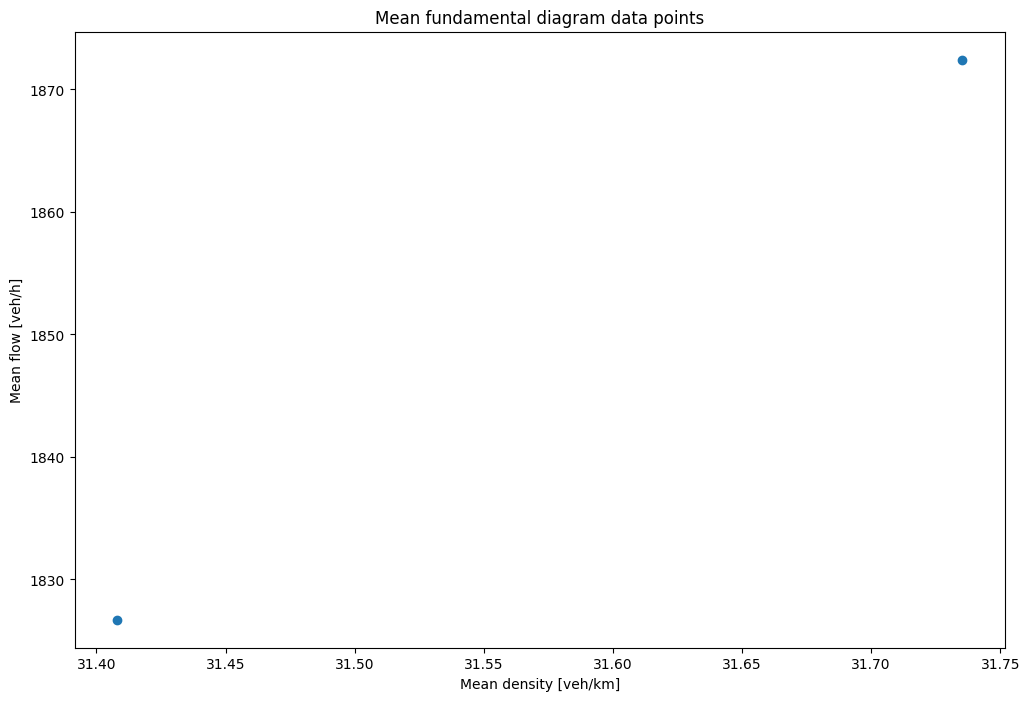

In [31]:
# show scatter plot
def show_fd_scatter_plot(df):
    plt.figure(figsize=(12,8))
    plt.scatter(df['mean_density'], df['mean_flow'])
    plt.xlabel('Mean density [veh/km]')
    plt.ylabel('Mean flow [veh/h]')
    plt.title('Mean fundamental diagram data points')
    plt.show()

# convert data
df_single_fd_c = df_single_fd.copy()
for col in df_single_fd_c.columns.tolist():
    if 'flow' in col:
        df_single_fd_c[col] = df_single_fd_c[col].astype(float) * 3600
    if 'density' in col:
        df_single_fd_c[col] = df_single_fd_c[col].astype(float) * 1000
    if 'speed' in col:
        df_single_fd_c[col] = df_single_fd_c[col].astype(float) * 3.6

show_fd_scatter_plot(df_single_fd_c)

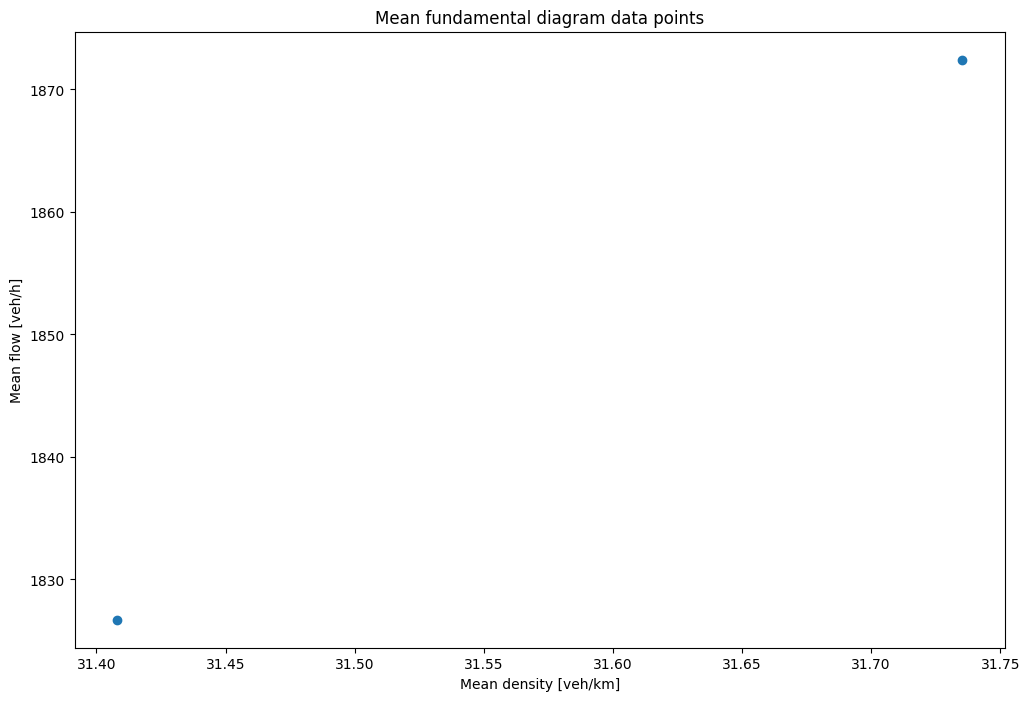

In [33]:
# select box of data points
df_single_fd_b = df_single_fd_c[(df_single_fd_c['mean_density'] > 30) & (df_single_fd_c['mean_density'] < 32)].copy()
df_single_fd_b = df_single_fd_b[(df_single_fd_b['mean_flow'] > 1800) & (df_single_fd_b['mean_flow'] < 3000)].copy()

# show refined scatter plot
show_fd_scatter_plot(df_single_fd_b)

In [34]:
# get range of demand variables
print("Main demand:", df_single_fd_c['main_demand'].min(), " - ", df_single_fd_c['main_demand'].max())
print("Ramp demand", df_single_fd_c['ramp_demand'].min(), " - ", df_single_fd_c['ramp_demand'].max())

Main demand: 4010.590760718779  -  4275.861562432236
Ramp demand 582.4741069036284  -  933.2923221983136


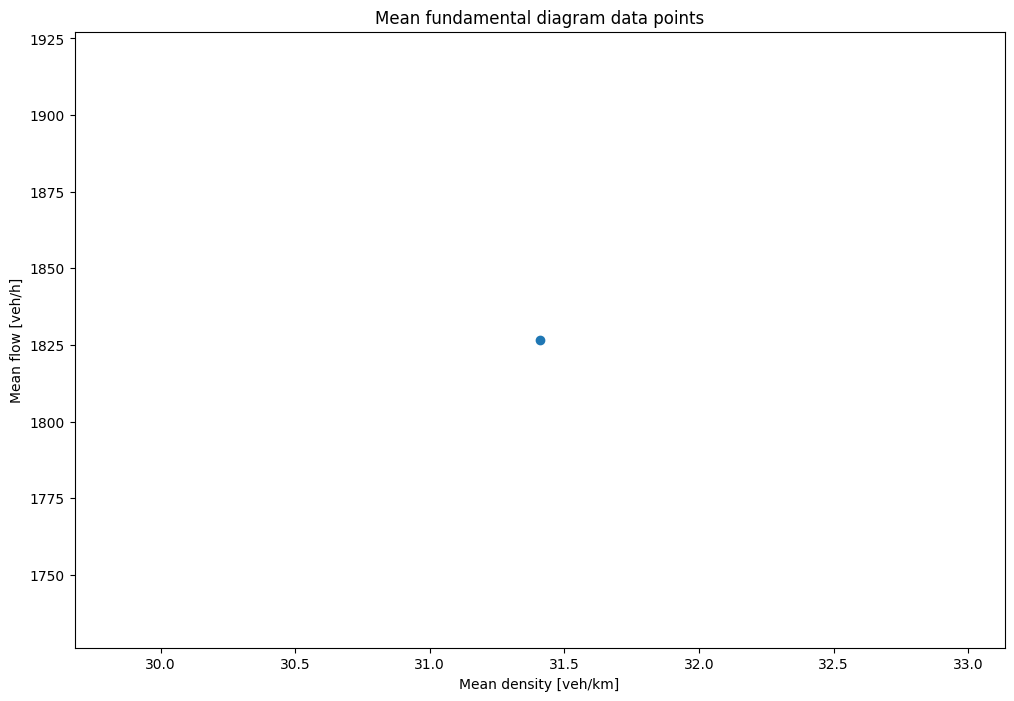

In [35]:
# refine scatter plot to search for suitable demand values
df_single_fd_r = df_single_fd_b[(df_single_fd_b['main_demand'] > 2000) & (df_single_fd_b['main_demand'] < 4100)].copy()
df_single_fd_r = df_single_fd_r[(df_single_fd_r['ramp_demand'] > 100) & (df_single_fd_r['ramp_demand'] < 1000)].copy()

# show refined scatter plot
show_fd_scatter_plot(df_single_fd_r)

### 1. Travel times
The travel time is used to determine the sample time. A traffic simulation should sample at least 3 times the maximum travel time.

An error occured when trying to read data from: C:\Users\jesse\Documents\Java\TrafficSimulation-workspace\traffic-sim\src\main\resources\full_level_runs_0\seed_0\run_1. This folder may contain a BadZipFile.


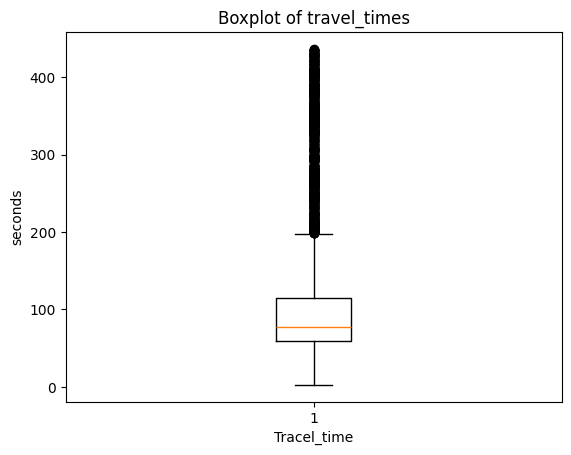

Lower Whisker: 2.572487896510296
Q1 (25th percentile): 59.63384758169771
Median (50th percentile): 77.10315410107009
Q3 (75th percentile): 114.76678302831307
Upper Whisker: 197.1146973608959
Mean: 110.88740620450857


In [53]:
# function to show boxplot stats
def show_boxplot_stats(df, column):
    # show statistics
    quartiles = df[column].quantile([0.25, 0.5, 0.75])
    q1 = quartiles[0.25]
    median = quartiles[0.5]
    q3 = quartiles[0.75]
    iqr = q3 - q1  # interquartile range
    lower_whisker = df[column][df[column] >= (q1 - 1.5 * iqr)].min()
    upper_whisker = df[column][df[column] <= (q3 + 1.5 * iqr)].max()
    mean = df[column].mean()
    
    # show the statistics
    boxplot_stats = {
        'Lower Whisker': lower_whisker,
        'Q1 (25th percentile)': q1,
        'Median (50th percentile)': median,
        'Q3 (75th percentile)': q3,
        'Upper Whisker': upper_whisker,
        'Mean': mean
    }
    for key, value in boxplot_stats.items():
        print(f'{key}: {value}')

# get travel times and remove NaN values which were created because of intermediate values for mean FD data
df_travel_time = load_dataframe(['mean_travel_time'], experiment_folder, intermediate_output)
df_travel_time = df_travel_time.dropna()

# create figure
fig, ax = plt.subplots()
# create boxplot
ax.boxplot(df_travel_time['mean_travel_time'])
# set title and labels
ax.set_title('Boxplot of travel_times')
ax.set_xlabel('Tracel_time')
ax.set_ylabel('seconds')

# show plot
plt.show()

# show stats
show_boxplot_stats(df_travel_time, 'mean_travel_time')

### 2. Analyse progress of simulation variables

Selected variables are chosen and their progress is plotted. It is likely that the values of a variable will approach a stable value. This stabalization will indicate that the simulation has achieved a stable state.

In [37]:
# selected warm-up time
# warm_up_time = None
warm_up_time = 364

An error occured when trying to read data from: C:\Users\jesse\Documents\Java\TrafficSimulation-workspace\traffic-sim\src\main\resources\full_level_runs_0\seed_0\run_1. This folder may contain a BadZipFile.
An error occured when trying to read data from: C:\Users\jesse\Documents\Java\TrafficSimulation-workspace\traffic-sim\src\main\resources\full_level_runs_0\seed_0\run_1. This folder may contain a BadZipFile.


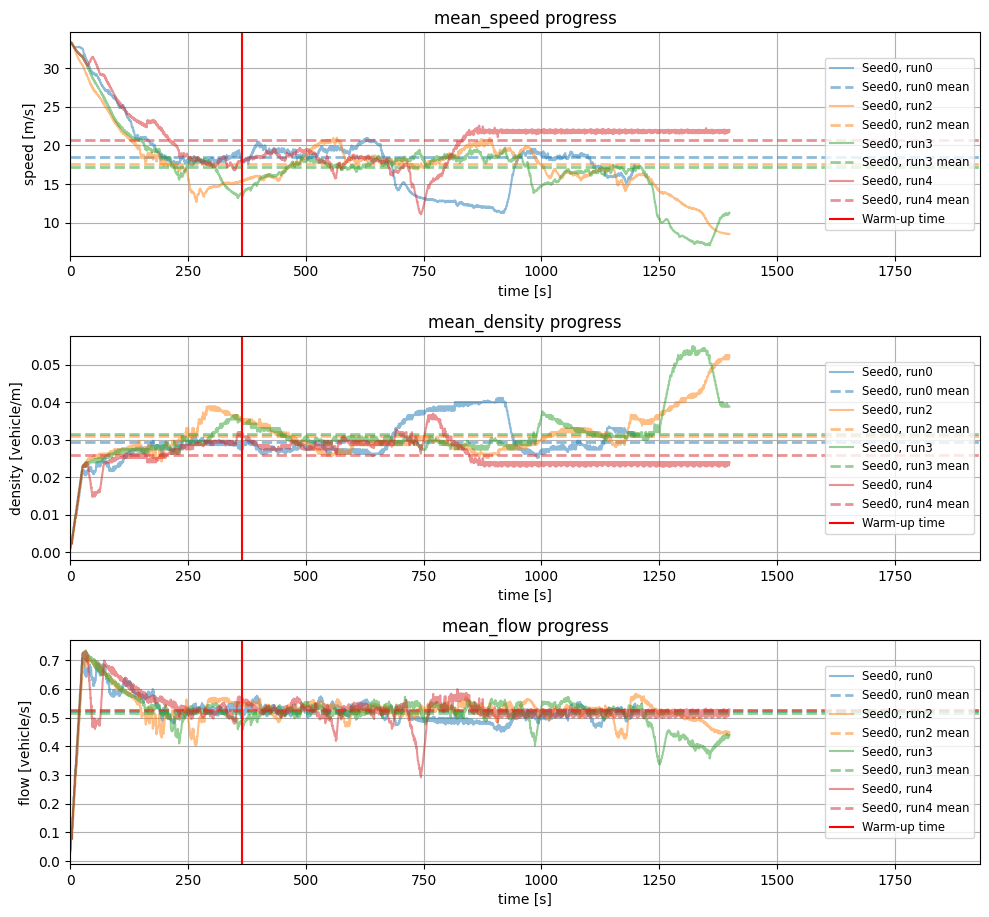

In [40]:
# get mean values
df_single = load_dataframe(['mean_speed', 'mean_density', 'mean_flow'], experiment_folder, single_output, input_values)
        
# only include mean variables (and seed and run numbers)
df_intermediate = load_dataframe(['mean_speed', 'mean_density', 'mean_flow'], experiment_folder, intermediate_output, input_values)
df_intermediate['time'] = df_intermediate['time'] = df_intermediate.groupby(['seed', 'run']).cumcount() / 2
variables_of_interest = ['time', 'seed', 'run', 'mean_speed', 'mean_flow', 'mean_density']
columns_to_include = [col for col in df_intermediate.columns if col in variables_of_interest]
df_filtered = df_intermediate[columns_to_include]

# create plots for all variables
n_columns = 1
n_rows = (len(df_filtered.columns) + 1) // n_columns
fig, axes = plt.subplots(n_rows, n_columns, figsize=(10, n_rows * 3))
axes = axes.flatten()

# Loop through each variable/column
for i, column in enumerate(df_filtered.columns.drop(['time', 'seed', 'run'])):
    # Group by 'run' and 'seed' combination
    run_seed_grouped = df_filtered.groupby(['run', 'seed'])

    # plot each run-seed combination
    for (run, seed), run_seed_group in run_seed_grouped:
        # plot line
        run_seed_group.reset_index()
        line, = axes[i].plot(run_seed_group['time'], run_seed_group[column], label=f'Seed{seed}, run{run}', alpha=0.5)
        line_color = line.get_color()
    
        # plot mean value
        if column in df_single.columns:
            final_mean_value = df_single[(df_single['seed'] == seed) & (df_single['run'] == run)][column].values[0]
            axes[i].axhline(final_mean_value, color=line_color, linestyle='--', linewidth=2, label=f'Seed{seed}, run{run} mean', alpha=0.5)

    # plot selected warm-up time
    if warm_up_time is not None:
        axes[i].axvline(x=warm_up_time, color='red', label='Warm-up time')
        
    # set plot titles and labels
    units = '-'
    if 'speed' in column:
        units = 'm/s'
    elif 'flow' in column:
        units = 'vehicle/s'
    elif 'density' in column:
        units = 'vehicle/m'
        
    axes[i].set_title(f'{column} progress')
    axes[i].set_xlabel('time [s]')
    axes[i].set_ylabel(f'{column.split("_")[1]} [{units}]')
    axes[i].grid(True)
    axes[i].legend(loc='right', fontsize='small')

    # extend only the right (x_max) and top (y_max) by 10%
    x_min, x_max = axes[i].get_xlim()
    y_min, y_max = axes[i].get_ylim()
    axes[i].set_xlim([0, x_max + 0.3 * (x_max - x_min)])
    
# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Show plots
plt.tight_layout()
plt.show()

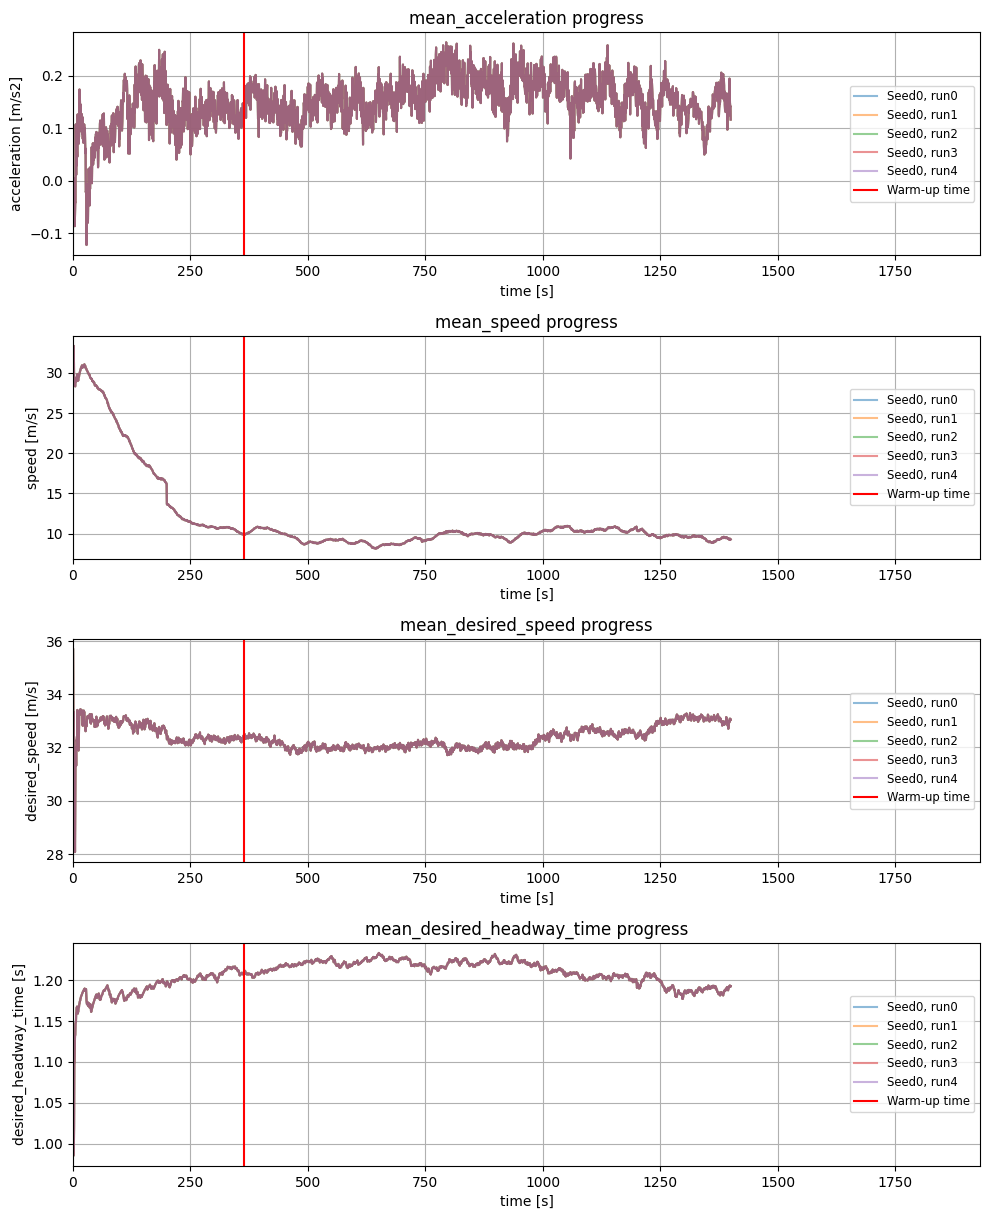

In [42]:
# only include mean variables (and seed and run numbers)
df_sequence = load_dataframe(['time', 'acceleration', 'speed', 'desired_speed', 'desired_headway_time'], experiment_folder, sequence_output, input_values)
variables_of_interest = ['time', 'seed', 'run', 'acceleration', 'speed', 'desired_speed', 'desired_headway_time']
columns_to_include = [col for col in df_sequence.columns if col in variables_of_interest]
df_filtered = df_sequence[columns_to_include]

# create plots for all variables
n_columns = 1
n_rows = (len(df_filtered.columns) + 1) // n_columns
fig, axes = plt.subplots(n_rows, n_columns, figsize=(10, n_rows * 3))
axes = axes.flatten()

# loop through each variable/column
for i, column in enumerate(df_filtered.columns.drop(['time', 'seed', 'run'])):
    # group by run and seed combination
    run_seed_grouped = df_filtered.groupby(['run', 'seed'])

    # plot each run-seed combination
    for (run, seed), run_seed_group in run_seed_grouped:
        # calculate mean per time step
        df_mean_by_time = df_sequence.groupby('time').agg({column: 'mean',}).reset_index()
        
        # plot line
        line, = axes[i].plot(df_mean_by_time['time'], df_mean_by_time[column], label=f'Seed{seed}, run{run}', alpha=0.5)
        line_color = line.get_color()

    # plot selected warm-up time
    if warm_up_time is not None:
        axes[i].axvline(x=warm_up_time, color='red', label='Warm-up time')

    # set plot titles and labels
    units = '-'
    if 'speed' in column:
        units = 'm/s'
    elif 'acceleration' in column:
        units = 'm/s2'
    elif 'time' in column:
        units = 's'
        
    axes[i].set_title(f'mean_{column} progress')
    axes[i].set_xlabel('time [s]')
    axes[i].set_ylabel(f'{column} [{units}]')
    axes[i].grid(True)
    axes[i].legend(loc='right', fontsize='small')

    # extend only the right (x_max) and top (y_max) by 10%
    axes[i].set_xlim([0, x_max + 0.3 * (x_max - x_min)])
    
# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Show plots
plt.tight_layout()
plt.show()

In [54]:
# # window size for sliding window significance test
# window_size = 115
# print(f'Window size: {window_size}\n')

# # only include mean variables (and seed and run numbers)
# variables_of_interest = ['time', 'seed', 'run', 'acceleration', 'speed', 'desired_speed', 'desired_headway_time']
# columns_to_include = [col for col in df_sequence.columns if col in variables_of_interest]
# df_filtered = df_sequence[columns_to_include]

# # dictionary to store warm-up times per variable
# warm_up_time_dict = {}

# # loop through each variable/column
# for i, column in enumerate(df_filtered.columns.drop(['time', 'seed', 'run'])):
#     # add column to dictionary with corresponding list
#     warm_up_time_dict[column] = []
    
#     # group by run and seed combination
#     run_seed_grouped = df_filtered.groupby(['run', 'seed'])

#     # loop through each run-seed combination
#     for (run, seed), run_seed_group in run_seed_grouped:
#         # calculate mean per time step
#         df_mean_by_time = df_sequence.groupby('time').agg({column: 'mean',}).reset_index()
#         df_mean_by_time.set_index('time', inplace=True)

#         # determine warm-up time
#         for t in range(window_size, len(df_mean_by_time)):
#             # compare the distribution of the variable before and after time `t`
#             pre_warmup = df_mean_by_time[column][t-window_size:t]
#             post_warmup = df_mean_by_time[column][t:t+window_size]
    
#             # ensure non-zero sizes for both slices
#             if len(pre_warmup) > 0 and len(post_warmup) > 0:
#                 # perform Mann-Whitney U Test
#                 stat, p_value = mannwhitneyu(pre_warmup, post_warmup)
    
#                 # determine if the null hypothesis is rejected (p-value > 0.05)
#                 if p_value > 0.05:
#                     warm_up_time = t
#                     warm_up_time_dict[column].append(warm_up_time)
                    
#                     # break after finding the warm-up time for this column
#                     break

# # show the warm-up times per variable
# for variable in warm_up_time_dict.keys():
#     warm_up_time_dict[variable].sort()
#     print(f'{variable}: warm-up times = {warm_up_time_dict[variable]}')

Window size: 115

acceleration: warm-up times = [163, 163, 163, 163, 163]
speed: warm-up times = [647, 647, 647, 647, 647]
desired_speed: warm-up times = [266, 266, 266, 266, 266]
desired_headway_time: warm-up times = [648, 648, 648, 648, 648]


### 3. Conclusions
Graphs of variable progress through simulation runs already showed that a warm-up time is required. In the first x seconds of the simulation, vehicles are filling up the freeway network and variables have a high variability during this period. While this variability remains high for the fundamental diagram variables (mean speed, mean flow and mean density), the individual GTU variables (acceleration, speed, desired headway etc.) do show stabilization after a while. A statistical significance test is performed on these variables to determine the duration of the warm-up time required to reach the stable state of the simulation. The result is a warm-up time of <b>364</b> seconds.

When this warm-up time is plotted into the variable progress graphs, the visuals clearly show that the post-warm-up duration of the simulation shows less variability than in the pre-warm-up duration.